<a href="https://colab.research.google.com/github/Dawson-Stutzman/DatasetGenerator/blob/main/DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Setup

In [1]:
!pip install pyspark
#from google.colab import drive
#drive.mount('/content/gdrive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=995250ed51a47b933e99c60644da7168a3cbf9deb533e2deac4a4288baad2ae4
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import pyspark.pandas as ps
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Window, SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, NumericType
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import time
from pyspark.sql.functions import udf, struct, when, exp, pow, lit, least
from pyspark.sql.functions import round as sqlround
from pyspark.sql.functions import sum as sqlsum
# round and sum are default functions, so the sqlsum and sqlround names are needed to differentiate
from pyspark.sql.types import *
from numpy.lib import math as M
from numpy import random as Random
################################
conf = SparkConf().setAppName("AppGen")
sc=SparkContext(conf=conf)
sc.setLogLevel("WARN")
sqlContext = SQLContext(sc)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Censor Equation Definitions (Not Yet Updated)

In [3]:
## NOTE: Right now the equation has been translated into terms of x instead of y for simpler lookups
def eq1(y: float):
  """Calculates a random age at which an event occurs:
  - y: The likelyhood of event. (Used to find the corrosponding age on the hazard function)
  => Returns the time corrosponding to y according to the equation below
  """
  #Changed from 12 -> 18
  return ((18 * M.sqrt(5)) * (M.sqrt(M.log(1 / y))))

def eq2(y: float):
  """Calculates a random age at which an event occurs:
  - y: The likelyhood of event. (Used to find the corrosponding age on the hazard function)
  => Returns the time corrosponding to y according to the equation below
  """
  return (60.6115 * M.pow((M.log(1/y)), 0.25))

def eq3(y: float):
  """Calculates a random age at which an event occurs:
  - y: The likelyhood of event. (Used to find the corrosponding age on the hazard function)
  => Returns the time corrosponding to y according to the equation below
  """
  return (80 * (M.sqrt(1 - y)))

def new_eq1(A: float, a: float, b: float,  c: float, t: float,  dose: float)
  val = (((b * c *(b * c - 2) + 2) * M.exp(b * c)) - ((a * c (a * c - 2) + 2) * M.exp(a * c))) \
  / M.pow(c, 3)
  return val

  # c Seems to be an exponential scalar value
  # The method will be called using Lambda notation as follows for Map Functions:
  # rdd.map(lambda x: new_eq1(A, a, b, c, 'Time','Dosage'))


# Time & Dosage Approximation Definitions

### <center>Time Approximation Function</center>
---
\begin{matrix}
  t_0 & \text{Entrance time}\\
  s & \text{Approximated exit time}\\
  a & \text{Individual's covariates}\\
  b & \text{Constant for fitting equations}\\
  u & \text{Random Likelyhood of event}\\
\end{matrix}
\begin{gather*}
  \\t_1 = \frac{2}{b} \Biggl(\ln \Bigl( -\frac{b}{2}\ln(u) + e^{a + \frac{b}{2} t_0} \Bigl) - a \Biggl)
\end{gather*}
\begin{matrix}\\
⇒ & t_1
\end{matrix}

In [4]:
def Get_Time_For_Dosage(t0, s: int, a=None, b=None):
  """Finds time of events using linnear reggression approx.
  - t0: The individual's entrance age
  - s: The seed for random event recreation
  - a: Covariates of an individual
  - b: Constant to fit the equation
  => approximate time of event as a float"""
  Random.seed(s)
  if b == None:
    d = Random.uniform(0.0, 30.0)
    b = (0.05 * t0 / 50) + (0.05 * t0 / 60)
  if a == None:
    a = -2.5
  Random.seed(s)
  u = Random.uniform(0.0, 1.0)
  return 2/b * ( M.log( ((-b / 2.0) * M.log(u)) + (M.exp(a + (b/2) * t0)) ) - a )


### <center>Dosage Functions</center>
---
\begin{matrix}
  t_0 & \text{Age at entrance}\\
  s & \text{Seed for recreatable dosage data}\\
  dx & \text{Dosage step size}\\\\
  ⇒ & \text{A dictionary of the individual's dosages at each step}
\end{matrix}

In [5]:

def Get_Dose_History(s, t0, dx=None):
  """Finds the dosage history of the individual while in the trial.
  - t0: The entrance age of the individual
  - s: The seed for random event recreation
  - dx: The interval to increase the value by
  => recreatable approximate dosage of an individual by time of exit"""
  t1 = Get_Time_For_Dosage(a=-2.5, t0=t0, s=s)
  if dx == None:
    dx = 0.1
  dose = 0
  Random.seed(s)
  dose_history = {0: 0.00}
  dose_history.update({t0 - dx: 0.00})
  age = t0

  while age <= t1:
    dose_history.update({age: dose + dx * Random.uniform(0.0, 1.0)})
    age += dx
    dose = [*dose_history.values()][-1]
  return dose_history;

def Get_Dose(s, t0, dx=None):
  """Finds the dosage of the individual at the time of exit.
  - t0: The entrance age of the individual
  - s: The seed for random event recreation
  - dx: The interval to increase the value by
  => recreatable approximate dosage of an individual by time of exit"""
  dose_history = Get_Dose_History(s=s, t0=t0, dx=dx)
  return [*dose_history.values()][-1];

### <center>Dosage Visualization</center>
---
\begin{matrix}
  t_0 & \text{Entrance age}\\
  s & \text{Seed for recreatable random dosage data}\\
  dx & \text{Dosage step size}\\\\
  ⇒ & \text{A graph representing dosage vs. age}
\end{matrix}

In [6]:
def Get_Dose_Graph(s, t0, dx=None):
  """Finds the dosage & it's graph of the individual at the time of exit.
  - t0: The entrance age of the individual
  - s: The seed for random event recreation
  - dx: The interval to increase the value by
  => recreatable approximate dosage of an individual by time of exit"""
  dose_history = Get_Dose_History(s=s, t0=t0, dx=dx)
  dose_history.update({0.0: 0.00})
  dose_history.update({[*dose_history.keys()][-1] + 10: [*dose_history.values()][-1]})

  fig=plt.figure()
  ax=fig.add_subplot(1,1,1)
  ax.plot(dose_history.keys(), dose_history.values())
  ax.set_title("Seed " + str(s))
  plt.tight_layout()
  plt.show()

# Dataset Generation Function Definition

In [7]:
import random
def Create_Dataset_SparkContext(Set_Size, Input=None, Output=None, Decimal_Precision=None, sort=None, ascending=None):
  """Creates a dataset of random individuals which are then censored via the hazard function definitions
  - Set_Size: The number of individuals to represent (affects person years)
  - Input: Specifies where the input .parquet file should be read from. If left empty, the function will create its own starting data to censor
  - Output: Specifies where the output .parquet file should be written and Overwritten. If left Empty, Dataset will print to console
  - Decimal_Precision: The number of decimal places to round to
  """
  if Decimal_Precision is None: Precision = 12 # Set the decimal place precision for the output
  else: Precision = Decimal_Precision
  data = [] # Check if the input Parameter is used and provides a path to a .parquet file
  if Input != None: df = sqlContext.read.parquet(Input) # Create a dataset for possible individuals before censoring is done.
  else:
    for i in range(0,  Set_Size):
      Entrance_Age = Random.uniform(18, 80)
      seed = random.randint(0, 1000000)
      Ev1 = eq1(Random.uniform(0.0, 1.0))
      Ev2 = eq2(Random.uniform(0.0, 1.0))
      Ev3 = eq3(Random.uniform(0.0, 1.0))
      Exit_Age = min(Ev1, Ev2, Ev3, 80.0)
      dose = Get_Dose(t0=Entrance_Age, s=seed)
      age = Entrance_Age
      dx = 0.1
      data.append({"-Index": i, "Included": 1,
                   "Smoker_Status": Random.randint(0, 3),
                   "Entrance_Age": Entrance_Age,
                   "Event1": Ev1, "Event2": Ev2, "Event3": Ev3,
                   "Dosage": dose,
                   "Sex": Random.randint(0, 2),
                   "Economic_Status": Random.randint(0, 7),
                   "Earliest_Event_Age": Exit_Age,
                   "Dosage_Seed": seed})
  psdf = sc.parallelize(data)
  df = psdf.toDF()
  df = df.withColumn("Included", when((df["Earliest_Event_Age"] > df["Entrance_Age"]), 0).otherwise(1))# Censor cases where Individuals have not yet reached an event
  df = df.withColumn('Earliest_Event', when(df["Earliest_Event_Age"] == df["Event1"], 1).when(df["Earliest_Event_Age"] == df["Event2"], 2).otherwise(2)) # I assumed that people over 80 would automatically be removed from our set, so the person years are 80 - entrance age
  df = df.withColumn("Person_Years", sqlround((df["Earliest_Event_Age"] - df["Entrance_Age"]), Precision))
  df = df.withColumn("Dosage", sqlround(df["Dosage"], Precision))
  df = df.withColumn("Earliest_Event_Age", sqlround(df["Earliest_Event_Age"], Precision))
  df = df.withColumn("Event1", sqlround(df["Event1"], Precision))
  df = df.withColumn("Event2", sqlround(df["Event2"], Precision))
  df = df.withColumn("Event3", sqlround(df["Event3"], Precision))
  df = df.withColumn("Entrance_Age", sqlround(df["Entrance_Age"], Precision))
  df_filtered=df.filter(df.Included == 0 )
  df_filtered=df_filtered.drop('Included')
  if sort != None:
    if ascending == None: ascending = False
    df_filtered = df_filtered.orderBy(sort, ascending=ascending)
  else:
    if ascending == None: ascending = False
    df_filtered = df_filtered.orderBy('-Index', ascending=True)
  if ascending == True and sort==None:
    df_filtered = df_filtered.orderBy('-Index', ascending=False)
  if Output is None:
    df_filtered.show()
    df_filtered.select(sqlround(sqlsum(df["Person_Years"]), Precision).alias('Total_Person_Years')).show()
  else:
    df.write.parquet(Output, 'overwrite')

# Testing Code Functionality

Age Approximation: 74.19300559756346
Final Dosage: 31.6007005554674


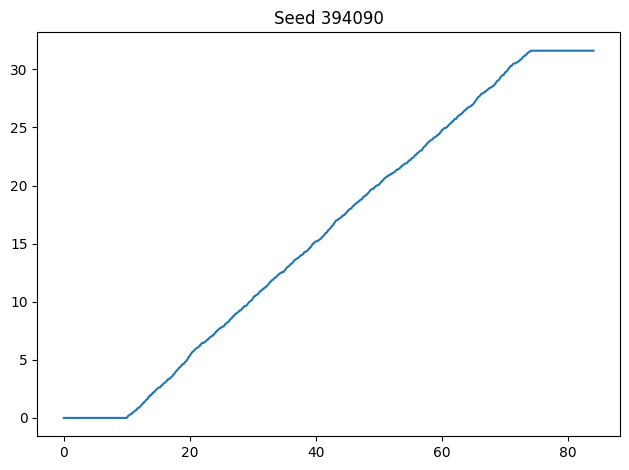

+------+------+-----------+------------------+---------------+------------+------+------+------+---+-------------+--------------+------------+
|-Index|Dosage|Dosage_Seed|Earliest_Event_Age|Economic_Status|Entrance_Age|Event1|Event2|Event3|Sex|Smoker_Status|Earliest_Event|Person_Years|
+------+------+-----------+------------------+---------------+------------+------+------+------+---+-------------+--------------+------------+
|     3| 0.463|     104535|            48.069|              0|      21.797|48.069|52.368|67.585|  0|            2|             1|      26.272|
|    12|  6.15|     187013|            39.326|              1|      35.573|39.326|70.865|56.987|  0|            0|             1|       3.753|
|    24| 0.128|     595532|            39.759|              3|      38.778|39.759|52.098|63.384|  1|            1|             1|       0.981|
|    27| 4.485|     418443|             63.22|              6|      35.457| 63.22|78.556|77.388|  1|            1|             1|      27.763|

In [8]:
Time1 = 10
Seed1 = 394090
print("Age Approximation: " + str(Get_Time_For_Dosage(t0=Time1, s=Seed1)))
print("Final Dosage: " + str(Get_Dose(t0=Time1, s=Seed1)))
Get_Dose_Graph(t0=Time1, s=Seed1)

Create_Dataset_SparkContext(Set_Size=10000, Decimal_Precision=3)